<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/Wine_DecisionTree_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Wine with Decision Tree & Random Forest  </center></h1>

The purpose of this project is to practice the ML techniques of **Decision Tree** & **Random Forest** with the sklearn built-in dataset **wine**, and compare the similarities and differences between  **Decision Tree** & **Random Forest**.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 24px">
    <ol>
        <li><a href="#Part Two">Part One: Decision Tree from sklearn</a></li>
      <li><a href="#Part Three">Part Two: Random Forest from sklearn</a></li>
    </ol>
</div>
<br>
<hr>

# Part One: Decision Tree

## 0: Import Libraries

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 1. upload the wine dataset

In [0]:
wine = load_wine()

In [0]:
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

In [84]:
wine_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1)
wine_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### 2. Split the data into training, testing datasets

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)  # choose 20% of the data as validation dataset

### 3. Create and train the Decision Tree model

In [86]:
# create the model
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
score

0.9629629629629629

### 4. Decision Tree Visualization

In [0]:
#!pip install graphviz

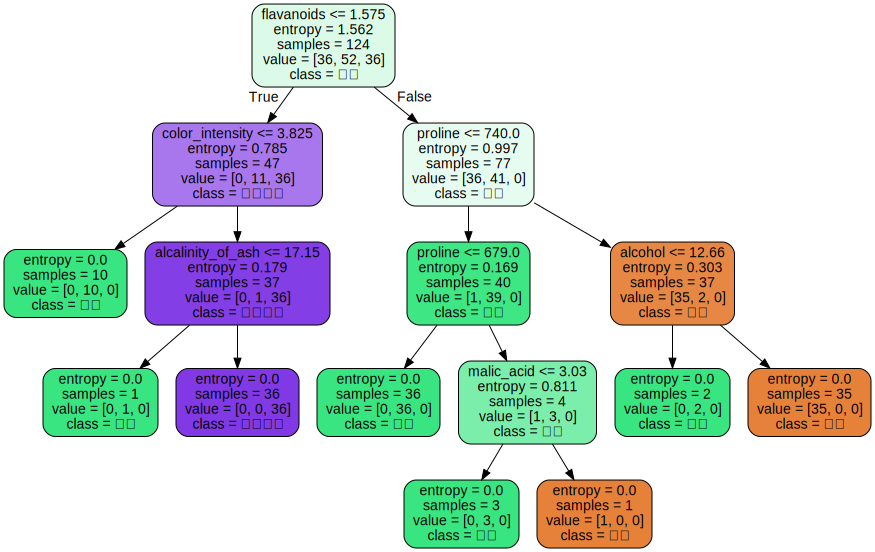

In [88]:
#feature_name = ["酒精", "苹果酸", "灰", "灰的碱性", "镁", "总酚", "类黄酮", "非黄烷类酚类", "花青素", "颜色强度", "色调", "od280/od315稀释葡萄酒", "脯氨酸"]
import graphviz

dot_data = export_graphviz(clf
                           ,feature_names = feature_names
                          ,class_names = ["琴酒", "雪莉", "贝尔摩德"] # target_names
                          ,filled = True
                          ,rounded = True
                          )
graph = graphviz.Source(dot_data)
graph

From the tree graph above, only three features are used to determine the tree. 

In [89]:
feature_importance = [*zip(feature_names, clf.feature_importances_)]
sorted_feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)
sorted_feature_importance

[('flavanoids', 0.4131024938753796),
 ('proline', 0.32167057988138953),
 ('color_intensity', 0.15626202686844184),
 ('alcohol', 0.057960870491628284),
 ('alcalinity_of_ash', 0.034247526308054214),
 ('malic_acid', 0.01675650257510657),
 ('ash', 0.0),
 ('magnesium', 0.0),
 ('total_phenols', 0.0),
 ('nonflavanoid_phenols', 0.0),
 ('proanthocyanins', 0.0),
 ('hue', 0.0),
 ('od280/od315_of_diluted_wines', 0.0)]

### 4. Decision Tree model fine tune (parameters adjusting)

#### Main parameters:
- **Criterion**: entropy (more sensitive to impurity), gini(default)
- **random_state**: to make the random all the same each time
- **splitter**: 
  - best (default) - the model will select the best features based on features importance
  - random - the model will random select sqrt of features
- **max_depth**: to avoid overfitting
- **min_samples_leaf** & **min_samples_split**
- **max_features**: 
- **min_impurity_split**: if the info gain < the value, the split will not happen

### 5. Prune the tree by seting the max_depth, min_samples_leaf, min_samples_split

#### 5.1 Visualization of the score with different Max_depth

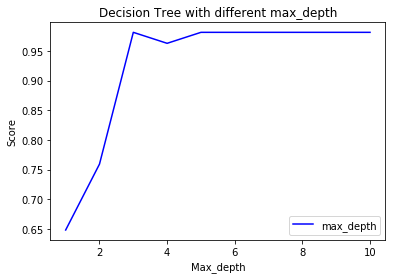

In [90]:
scores = []
for i in range(1, 11):
  clf = DecisionTreeClassifier(max_depth = i
                            ,criterion = "entropy"
                            ,random_state = 30
                            ,splitter = "random"
                            ,min_samples_leaf = 3
                            ,min_samples_split = 3
                              )
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  scores.append(score)

plt.plot(range(1, 11), scores, color = "b", label = "max_depth")
plt.title("Decision Tree with different max_depth")
plt.xlabel('Max_depth')
plt.ylabel('Score')
plt.legend()
plt.show()

In [91]:
print("Best performance: {}".format(max(scores)))
print("Max_dept: {}".format(scores.index(max(scores)) + 1))

Best performance: 0.9814814814814815
Max_dept: 3


#### 4.1.2 Visualization of the score with different Min_samples_leaf

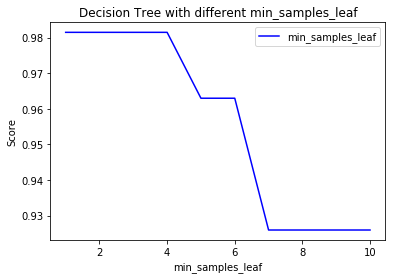

In [92]:
scores = []
for i in range(1, 11):
  clf = DecisionTreeClassifier(max_depth = 3
                            ,criterion = "entropy"
                            ,random_state = 30
                            ,splitter = "random"
                            ,min_samples_leaf = i
                            ,min_samples_split = 3)
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  scores.append(score)

plt.plot(range(1, 11), scores, color = "b", label = "min_samples_leaf")
plt.title("Decision Tree with different min_samples_leaf")
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.legend()
plt.show()

In [93]:
print("Best performance: {}".format(max(scores)))
print("Min_samples_leaf: {}".format(scores.index(max(scores)) + 1))

Best performance: 0.9814814814814815
Min_samples_leaf: 1


#### 4.1.3 VIsualization of the scores with different Min_samples_split

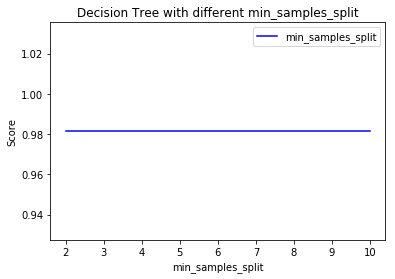

In [94]:
# the minimum value of min_samples_split = 2
scores = []
for i in range(2, 11):
  clf = DecisionTreeClassifier(max_depth = 3
                            ,criterion = "entropy"
                            ,random_state = 30
                            ,splitter = "random"
                            ,min_samples_leaf = 3
                            ,min_samples_split = i)
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  scores.append(score)

plt.plot(range(2, 11), scores, color = "b", label = "min_samples_split")
plt.title("Decision Tree with different min_samples_split")
plt.xlabel('min_samples_split')
plt.ylabel('Score')
plt.legend()
plt.show()

In [95]:
print("Best performance: {}".format(max(scores)))
print("Min_samples_split: {}".format(scores.index(max(scores)) + 2))

Best performance: 0.9814814814814815
Min_samples_split: 2


**The best performance model: 98.14%**
- Max_depth = 3
- Min_samples_leaf = 1
- Min_samples_split = 2

In [96]:
clf = DecisionTreeClassifier(max_depth = 3
                            ,criterion = "entropy"
                            ,random_state = 30
                            ,splitter = "random"
                            ,min_samples_leaf = 1
                            ,min_samples_split = 2)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
score

0.9814814814814815

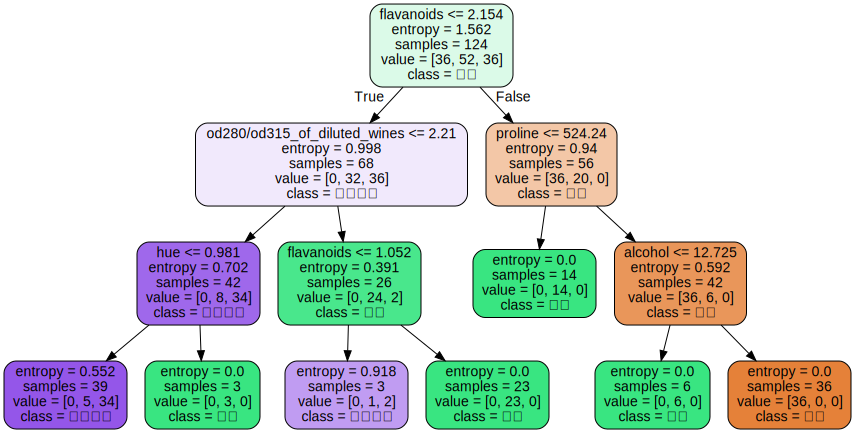

In [97]:
dot_data = export_graphviz(clf
                           ,feature_names = feature_names
                          ,class_names = ["琴酒", "雪莉", "贝尔摩德"] # target_names
                          ,filled = True
                          ,rounded = True
                          )
graph = graphviz.Source(dot_data)
graph

# Part Two: RandomForest

## 1. Create and train the RandomForest model

In [98]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 25)
rfc.fit(x_train, y_train)
result = rfc.score(x_test, y_test)
result

0.9629629629629629

## 2. Decision Tree model fine tune (parameters adjusting)

### Main parameters:
>Parameters | Explanation
>--- | --- 
>**Criterion** | entropy (more sensitive to impurity), gini(default)
>**random_state** | to make the random all the same each time 
>**splitter _ 1:** | best (default) - the model will select the best features based on features importance
>**splitter _ 2:**| random - the model will random select sqrt of features
>**max_depth** | to avoid overfitting
>**min_samples_leaf** & **min_samples_split** | numerical missing value as one class
>**max_features** | categorical 
>**min_impurity_split** | if the info gain < the value, the split will not happen 


# Part Three: Decision Tree Limitations

- The current strategy of creating trees is greedy. We can only get the local optimal.

It iwill find the largest information gain right now and split on that feature. We never consider the ramifications of that split futher down the tree. 

Finding a globally optimal tree is an extremely difficult task, and finding a tree using our greedy approach is reasonable substitute.

- Another problem with our trees is that they potentially overfit the data. 

This means that the structure of the tree is too dependent on the training data and doesn't accurately represent the way the data in the real world looks like. In general, larger trees tend to overfit the data more. As the tree gets bigger, it becomes more tuned to the training data and it loses a more generalized understanding of the real world data

One way to solve the overfitting problem is to prune the tree. The goal of pruning is to shrink the size of the tree. There are a few different pruning strategies. 

## Other notes: transform string variable into numerical